# Graph Learning
## Lab 5: Heat Diffusion

In this lab, you will learn to use heat diffusion for **contrastive ranking** and **node classification**.

## Import

In [102]:
from IPython.display import SVG

In [103]:
import numpy as np
from scipy import sparse

In [104]:
from sknetwork.data import load_netset, grid, karate_club
from sknetwork.regression import Dirichlet
from sknetwork.classification import DiffusionClassifier
from sknetwork.ranking import PageRank
from sknetwork.utils import directed2undirected
from sknetwork.visualization import visualize_graph
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph + bipartite graph)

In [105]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Grid

We first illustrate the notion of **contrastive ranking** on a $k\times k$ grid.

In [106]:
k = 5
datasetGrid = grid(k, k, True)
adjacencyGrid = datasetGrid.adjacency
positionGrid = datasetGrid.position

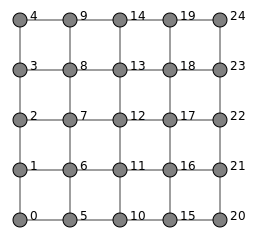

In [107]:
image = visualize_graph(adjacencyGrid, positionGrid, names=np.arange(k * k), width=200, height=200)
SVG(image)

## To do

* Display the solution to the Dirichlet problem with 1 hot source and 1 cold source, located on the opposite corners of the square.
* Add a hot source at the top-left corner of the square. What is the free node of highest temperature?

In [108]:
dirichlet = Dirichlet()

In [109]:
bottom_left = 0
top_right = k * k - 1

In [110]:
values = {bottom_left: 0, top_right: 1}

In [111]:
temperatures = dirichlet.fit_predict(adjacencyGrid, values=values)

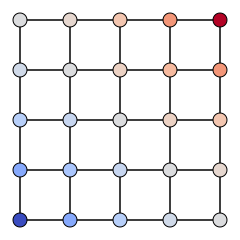

In [112]:
image = visualize_graph(adjacencyGrid, positionGrid, scores=temperatures, width=200, height=200)
SVG(image)

In [113]:
# add hot source
top_left = k-1
values[top_left] = 1
temperatures = dirichlet.fit_predict(adjacencyGrid, values=values)

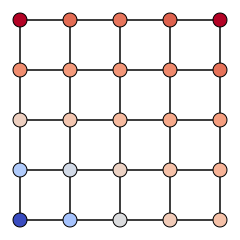

In [114]:
image = visualize_graph(adjacencyGrid, positionGrid, scores=temperatures, width=200, height=200)
SVG(image)

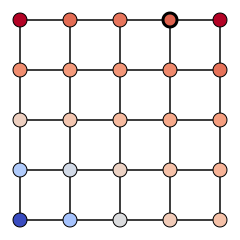

In [115]:
# find free node with highest temperature
mask = np.ones(k * k, dtype=bool)   # mask of nodes
mask[list(values)] = 0              # only free nodes in mask
i = np.argmax(temperatures[mask])   # hottest free node
hot = np.flatnonzero(mask)[i]

image = visualize_graph(adjacencyGrid, positionGrid, scores=temperatures, seeds=hot, width=200, height=200)
SVG(image)

## Karate Club


We now consider the **classification** of nodes by heat diffusion. We use the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) that has ground-truth labels.

In [116]:
datasetKC = karate_club(True)

In [117]:
adjacencyKC = datasetKC.adjacency
positionKC = datasetKC.position
labels_true_KC = datasetKC.labels

In [118]:
n = len(labels_true_KC)

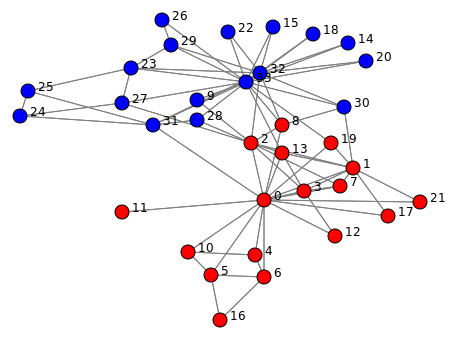

In [119]:
image = visualize_graph(adjacencyKC, positionKC, labels=labels_true_KC, names=np.arange(n))
SVG(image)

## To do

* Select one node in each ground-truth cluster, and predict the labels of the other nodes by heat diffusion.
* Display the graph with the predicted labels. 
* What is the accuracy of the classification?

In [120]:
classifier = DiffusionClassifier()

In [121]:
labels = labels_true_KC.copy()
seeds = np.array([16, 26])
mask = np.zeros(len(labels), dtype=bool)
mask[seeds] = 1
labels[~mask] = -1

In [122]:
labels_pred = classifier.fit_predict(adjacencyKC, labels)

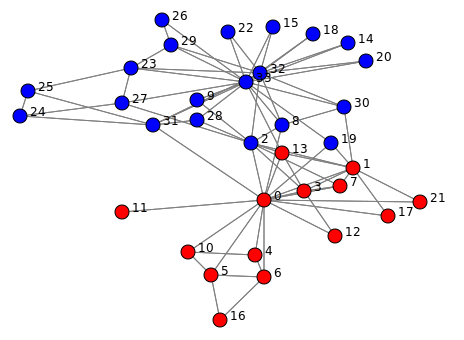

In [123]:
image = visualize_graph(adjacencyKC, positionKC, labels=labels_pred, names=np.arange(len(labels_true_KC)))
SVG(image)

In [124]:
# accuracy
print(np.mean(labels_pred == labels_true_KC))

0.9117647058823529


## To do

The classifier applies temperature centering after diffusion.

* Repeat the same experiment without temperature centering.
* Do the same experiments with 3 nodes in a ground-truth cluster and 1 in the other.
* Comment the results.

In [125]:
classifier = DiffusionClassifier(centering=False)

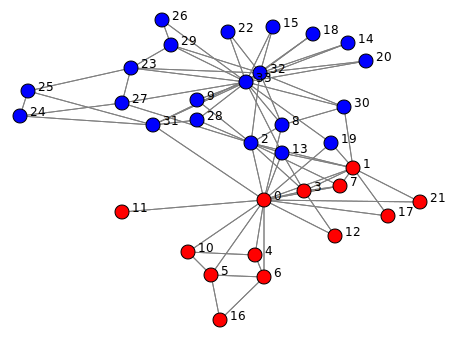

In [126]:
labels_pred = classifier.fit_predict(adjacencyKC, labels)

image = visualize_graph(adjacencyKC, positionKC, labels=labels_pred, names=np.arange(len(labels_true_KC)))
SVG(image)

In [127]:
# accuracy
print(np.mean(labels_pred == labels_true_KC))

0.8823529411764706


In [128]:
# new training - 3 nodes vs 1 node
labels = labels_true_KC.copy()
seeds = np.array([0, 10, 16, 26])
mask = np.zeros(len(labels), dtype=bool)
mask[seeds] = 1
labels[~mask] = -1

In [129]:
labels_pred = classifier.fit_predict(adjacencyKC, labels)
print(np.mean(labels_true_KC == labels_pred)) # accuracy

0.5588235294117647


**Answer**: Without centering, the classification is biased towards the class with more seeds, thus decreasing the accuracy in comparison to the previous training. We can see below that with the same nodes, but using centering, we can increase the accuracy again.

In [130]:
classifier = DiffusionClassifier(centering=True)
labels_pred = classifier.fit_predict(adjacencyKC, labels)
print(np.mean(labels_pred == labels_true_KC))

0.9705882352941176


## Openflights


We now show how to classify the nodes of a graph **without labels**. We identify some nodes of interest and use these seeds to classify the other nodes.

In [131]:
datasetOF = openflights

In [132]:
adjacencyOF = datasetOF.adjacency
positionOF = datasetOF.position
namesOF = datasetOF.names

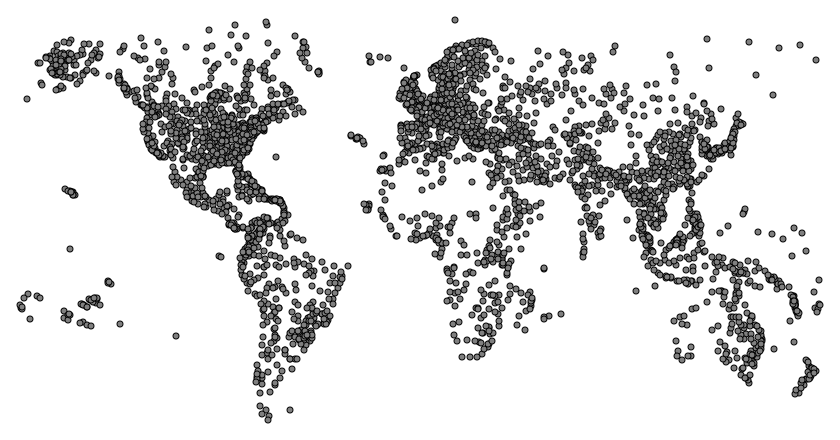

In [133]:
image = visualize_graph(adjacencyOF, positionOF, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the labels predicted for 3 seeds (Paris, New-York, Beijing), each with its own  label.
* Add Madrid with another label and comment the results.

In [134]:
paris = 622
newyork = 1842
beijing = 1618
madrid = 572

In [135]:
classifier = DiffusionClassifier()

labelsOF = {paris: 0, newyork: 1, beijing: 2}
labels_pred = classifier.fit_predict(adjacencyOF, labelsOF)

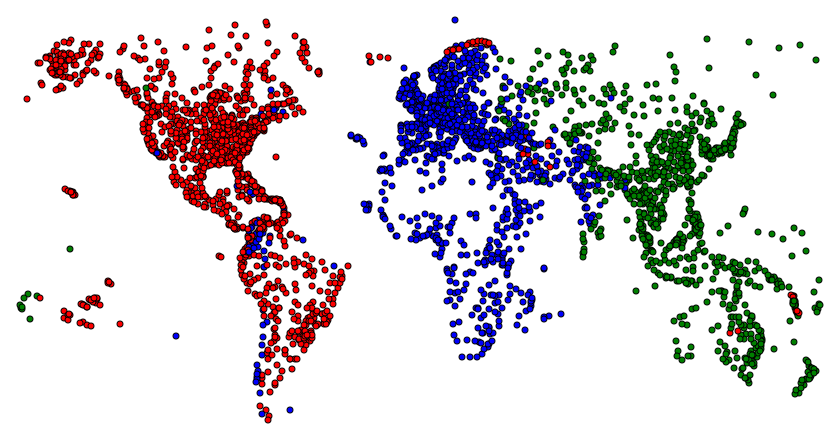

In [136]:
image = visualize_graph(adjacencyOF, positionOF, width=800, height=400, node_size=3, labels=labels_pred, display_edges=False)
SVG(image)

In [137]:
labelsOF[madrid] = 3
labels_pred = classifier.fit_predict(adjacencyOF, labelsOF)

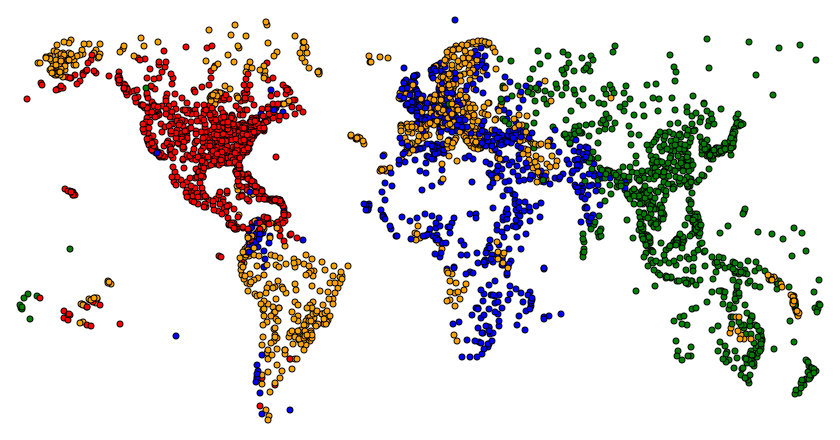

In [138]:
image = visualize_graph(adjacencyOF, positionOF, width=800, height=400, node_size=3, labels=labels_pred, display_edges=False)
SVG(image)

Finally, we illustrate **contrastive ranking** on Openflights.

**-- REFAZER --**  
A celula abaixo é o que o gpt fez, parece bem errado e no 2o item da prox to do list fala pra usar constrative ranking tbm mas de outro jeito

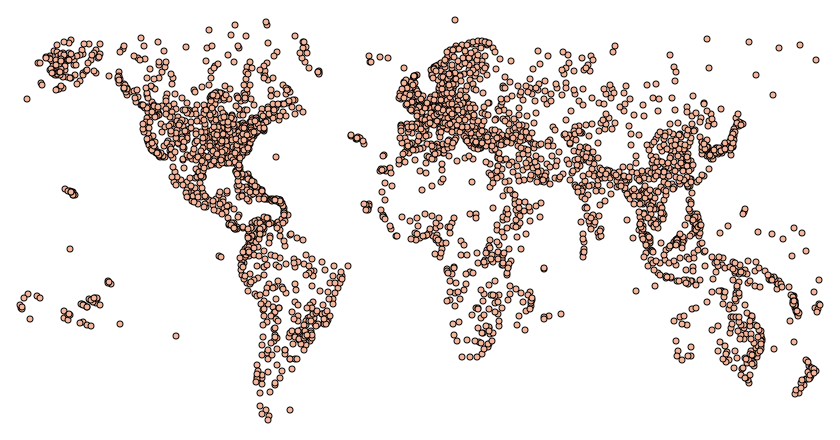

In [139]:
from sknetwork.ranking import PageRank

# Define seeds
paris = 622
newyork = 1842
beijing = 1618

# Step 1: PageRank centered on Paris + New York (Western airports)
pagerank = PageRank()
scores_pos = pagerank.fit_predict(adjacencyOF, weights={paris: 1, newyork: 1})

# Step 2: PageRank centered on Beijing (Eastern airport)
scores_neg = pagerank.fit_predict(adjacencyOF, weights={beijing: 1})

# Step 3: Contrastive scores (Western vs. Eastern influence)
contrastive_scores = scores_pos - scores_neg

# Step 4: Visualize contrastive ranking
image = visualize_graph(adjacencyOF, positionOF, scores=contrastive_scores, node_size=3, width=800, height=400, display_edges=False)
SVG(image)


## To do

* List the top-10 airports that are the closest to Tokyo in terms of Personalized PageRank.
* List of the top-10 airports that are both the closest to Tokyo and the furthest from Paris Charles de Gaulle, using heat diffusion (contrastive ranking).<br>What do you observe?
* Give the temperatures of these airports after heat diffusion and explain the result.

In [140]:
tokyo = 1084

In [141]:
# 10 closest to tokyo
pagerank = PageRank()
scores_pos = pagerank.fit_predict(adjacencyOF, weights={tokyo: 1})
top_pagerank = np.argsort(-scores_pos)[:10]
print(namesOF[top_pagerank])

['Tokyo Haneda International Airport' 'Incheon International Airport'
 'Naha Airport' 'Taiwan Taoyuan International Airport'
 'Osaka International Airport' 'Shanghai Pudong International Airport'
 'New Chitose Airport' 'Kansai International Airport'
 'Narita International Airport' 'Chubu Centrair International Airport']


In [ ]:
# tokyo vs paris
dirichlet = Dirichlet()
values = {paris: 0, tokyo: 1}
scores_pos = dirichlet.fit_predict(adjacencyOF, values)
top_diffusion = np.argsort(-scores_pos)[:10]
print(namesOF[top_diffusion])

['Kitakyūshū Airport' 'Tokushima Airport' 'Tokachi-Obihiro Airport'
 'Oshima Airport' 'Tokyo Haneda International Airport' 'Tottori Airport'
 'Hachijojima Airport' 'Izumo Airport' 'Monbetsu Airport' 'Shonai Airport']


In [143]:
for i, idx in enumerate(top_diffusion):
    name = namesOF[idx]
    temp = scores_pos[idx]
    print(f"{i+1}. {name}: temperature = {temp:.4f}")

1. Kitakyūshū Airport: temperature = 1.0000
2. Tokushima Airport: temperature = 1.0000
3. Tokachi-Obihiro Airport: temperature = 1.0000
4. Oshima Airport: temperature = 1.0000
5. Tokyo Haneda International Airport: temperature = 1.0000
6. Tottori Airport: temperature = 1.0000
7. Hachijojima Airport: temperature = 1.0000
8. Izumo Airport: temperature = 1.0000
9. Monbetsu Airport: temperature = 1.0000
10. Shonai Airport: temperature = 1.0000


## Wikipedia Vitals

We now consider the graph of links of WikiVitals, considered as undirected. We first focus on **constrastive ranking**, then on **node classification**.

In [144]:
datasetWV = wikivitals

In [145]:
adjacencyWV = datasetWV.adjacency
namesWV = datasetWV.names
labelsWV = datasetWV.labels
names_labels_WV = datasetWV.names_labels

In [146]:
adjacency = directed2undirected(adjacencyWV)

## Contrastive ranking

## To do

* List the top-10 articles that are close to **Cat** and **Dog** in terms of Personalized PageRank.
* Compare with the list of top-10 articles that are close to **Cat** and **Dog** and far from **Bear** and **Tiger** using heat diffusion (contrastive ranking).
* List the top-10 articles that are close to **Bear** and **Tiger** and far from **Cat** and **Dog** (you can use previous diffusion). Interpret the results.

In [147]:
pagerank = PageRank()

In [148]:
pagerank.fit(adjacency, force_bipartite=True)

PageRank(damping_factor=0.85, solver='piteration', n_iter=10, tol=1e-06)

In [149]:
# Top 10 scores for cat and dog

dog_index = [i for i, name in enumerate(namesWV) if 'dog' == name.lower()]
cat_index = [i for i, name in enumerate(namesWV) if 'cat' == name.lower()]
print(f"Index: {dog_index}, Name: {namesWV[dog_index]}")
print(f"Index: {cat_index}, Name: {namesWV[cat_index]}")

cd_perso_scores = pagerank.fit_predict(adjacencyWV, {dog_index[0]: 1, cat_index[0]: 1})
ranked_indices_cd = np.argsort(cd_perso_scores)[-10:][::-1]

print("\n Top 10 closest articles to cat and dog\n")
for rank, i in enumerate(ranked_indices_cd, 1):
    print(f"{rank}. {datasetWV.names[i]} (score: {cd_perso_scores[i]:.4f})")

Index: [2468], Name: ['Dog']
Index: [1497], Name: ['Cat']

 Top 10 closest articles to cat and dog

1. Dog (score: 0.0767)
2. Cat (score: 0.0765)
3. Taxonomy (biology) (score: 0.0030)
4. Animal (score: 0.0029)
5. Mammal (score: 0.0026)
6. Chordate (score: 0.0024)
7. Latin (score: 0.0024)
8. Carl Linnaeus (score: 0.0020)
9. World War II (score: 0.0020)
10. Carnivora (score: 0.0020)


In [150]:
# Top 10 scores for cat and dog and far from bear and tiger

diffusionWV = Dirichlet()

bear_index = [i for i, name in enumerate(namesWV) if 'bear' == name.lower()]
tiger_index = [i for i, name in enumerate(namesWV) if 'tiger' == name.lower()]

print(f"Index: {bear_index}, Name: {namesWV[bear_index]}")
print(f"Index: {tiger_index}, Name: {namesWV[tiger_index]}")

bt_perso_scores = diffusionWV.fit_predict(adjacencyWV,
                                            {dog_index[0]: 1,
                                            cat_index[0]: 1,
                                            bear_index[0]: 0,
                                            tiger_index[0]: 0})

ranked_indices_cd = np.argsort(bt_perso_scores)[-10:][::-1]

print("\n Top 10 closest articles to cat and dog and far from bear and tiger\n")
for rank, i in enumerate(ranked_indices_cd, 1):
    print(f"{rank}. {datasetWV.names[i]} (score: {bt_perso_scores[i]:.4f})")

Index: [963], Name: ['Bear']
Index: [9126], Name: ['Tiger']

 Top 10 closest articles to cat and dog and far from bear and tiger

1. Cat (score: 1.0000)
2. Dog (score: 1.0000)
3. Terrier (score: 0.6790)
4. Retriever (score: 0.5434)
5. Great Dane (score: 0.5367)
6. Mouse (score: 0.5350)
7. Moulting (score: 0.5328)
8. Skink (score: 0.5320)
9. Lyrebird (score: 0.5278)
10. Budgerigar (score: 0.5270)


In [158]:
# Top 10 scores for bear and tiger and far from cat and dog

ranked_indices_cd = np.argsort(-bt_perso_scores)[-10:][::-1]

print("\n Top 10 closest articles to bear and tiger and far from cat and dog\n")
for rank, i in enumerate(ranked_indices_cd, 1):
    print(f"{rank}. {datasetWV.names[i]} (score: {bt_perso_scores[i]:.4f})")


 Top 10 closest articles to bear and tiger and far from cat and dog

1. Bear (score: 0.0000)
2. Gloss (optics) (score: 0.0000)
3. Goby (score: 0.0000)
4. Tiger (score: 0.0000)
5. Serranidae (score: 0.4603)
6. Endangered species (score: 0.4727)
7. Hibernation (score: 0.4745)
8. Malay Peninsula (score: 0.4777)
9. Taxidermy (score: 0.4819)
10. Legendary creature (score: 0.4849)


## Node classification

We now use the ground-truth labels provided by the category of each article.

In [152]:
print(names_labels_WV)

['Arts' 'Biological and health sciences' 'Everyday life' 'Geography'
 'History' 'Mathematics' 'People' 'Philosophy and religion'
 'Physical sciences' 'Society and social sciences' 'Technology']


## To do

* What is the accuracy of node classification, using half of the nodes in the train set?
* Display the confusion matrix. What is the most difficult class to predict?
* Give examples of misclassification for each label (e.g., 2 false positives and 2 false negatives per label).

Accuracy: 0.7010


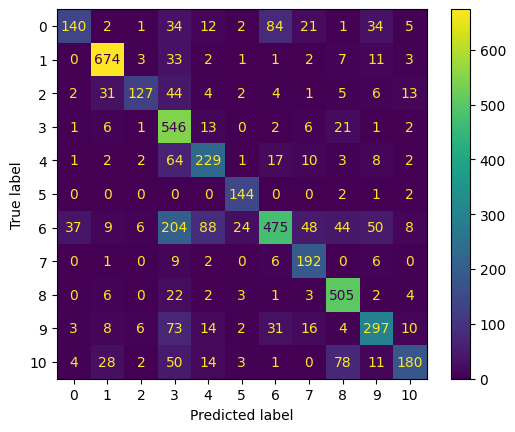

In [153]:
from sklearn import metrics
from matplotlib import pyplot as plt

num_nodes = adjacencyWV.shape[0]
full_labels = -1 * np.ones(num_nodes, dtype=int)
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(
    indices, test_size=0.5, stratify=labelsWV
)

full_labels[train_idx] = labelsWV[train_idx]

diff_clf = DiffusionClassifier()
diff_clf.fit(adjacencyWV, full_labels)

y_pred = diff_clf.predict()[test_idx]

labels_unique = np.unique(labelsWV[test_idx])

print(f"Accuracy: {accuracy_score(labelsWV[test_idx], y_pred):.4f}")

confusion_matrix = metrics.confusion_matrix(labelsWV[test_idx], y_pred, labels=labels_unique)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels_unique)

cm_display.plot()
plt.show()

In [154]:
from sklearn import metrics
from matplotlib import pyplot as plt

num_nodes = adjacency.shape[0]
full_labels = -1 * np.ones(num_nodes, dtype=int)
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(
    indices, test_size=0.5, stratify=labelsWV
)

full_labels[train_idx] = labelsWV[train_idx]

diff_clf = DiffusionClassifier()
diff_clf.fit(adjacency, full_labels)

# Faz predição apenas para os nós de teste
y_pred = diff_clf.predict()[test_idx]

print(f"Accuracy: {accuracy_score(labelsWV[test_idx], y_pred):.4f}")

confusion_matrix = metrics.confusion_matrix(labelsWV[test_idx], y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()
)

SyntaxError: unmatched ')' (1067518479.py, line 26)

RESPOSTA (A LABEL DE MATEMATICA É A MAIS DIFICIL DE CATEGORIZAR - MAS PQ?)

In [ ]:
true = labelsWV[test_idx]
pred = y_pred

# Obter todas as classes únicas
labels = np.unique(true)

false_positives = {label: [] for label in labels}
false_negatives = {label: [] for label in labels}

for i, (t, p, idx) in enumerate(zip(true, pred, test_idx)):
    if t != p:
        false_negatives[t].append(idx)
        false_positives[p].append(idx)

for label, i in enumerate(labels,0):
    fp_examples = false_positives[label][:2]
    fn_examples = false_negatives[label][:2]

    fp_names = [namesWV[i] for i in fp_examples]
    fn_names = [namesWV[i] for i in fn_examples]

    print(f"\nLabel {names_labels_WV[i]}:")
    print(f"  False Positives (predicted as {names_labels_WV[i]} but shouldn't be): {fp_names}")
    print(f"  False Negatives (should be {names_labels_WV[i]} but predicted otherwise): {fn_names}")

## To do

* Classify each article of the **People** category in one of the other categories (Mathematics, History, etc.), using all other labels.
* List the top-5 predicted people of each category using Personalized PageRank.

In [ ]:
people_label = 6
people_mask = (labelsWV == people_label)

# Cria labels com -1 para People, para o treino
labels_for_training = labelsWV.copy()
labels_for_training[people_mask] = -1

labels_pred = diff_clf.fit_predict(adjacency, labels_for_training)

people_indices = np.where(people_mask)[0]
people_labels_pred = labels_pred[people_indices]

In [ ]:

for label in np.unique(labelsWV):
    if label == people_label:
        continue

    mask = (labels_pred == label) & (labelsWV == people_label)
    if np.sum(mask) == 0:
        continue

    pagerank = PageRank()
    scores = pagerank.fit_predict(adjacency, mask, force_bipartite=True)
    scores *= mask

    top_indices = np.argsort(-scores)[:5]

    print(f"{names_labels_WV[label]}")
    for i in top_indices:
        print(f"  - {namesWV[i]} (score: {scores[i]:.4f})")
    print('---')



## 2. Bipartite graphs

Finally, we consider the bipartite graph between articles and words in WikiVitals.

In [ ]:
datasetWV = wikivitals
biadjacency = datasetWV.biadjacency

In [ ]:
words = datasetWV.names_col

## To do

* Repeat the experiments on node classification using the bipartite graph between articles and words.
* Which information seems to be richer, the text or the links between articles?
* Propose a solution exploiting both sources of information.

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt

num_nodes = biadjacency.shape[0]
full_labels = -1 * np.ones(num_nodes, dtype=int)
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(
    indices, test_size=0.5, stratify=labelsWV
)

full_labels[train_idx] = labelsWV[train_idx]

diff_clf = DiffusionClassifier()
diff_clf.fit(biadjacency, full_labels)

# Faz predição apenas para os nós de teste
bi_y_pred = diff_clf.predict()[test_idx]

print(f"\nAccuracy for bipartite graph: {accuracy_score(labelsWV[test_idx], bi_y_pred):.4f}")

confusion_matrix = metrics.confusion_matrix(labelsWV[test_idx], bi_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

RESPONDER

FAZER SOLUÇÃO